# Todo junto

Ahora que hemos visto todo lo que atañe a las redes convolucionales, vamos a entrenar el clasificador entre perros y gatos que hemos estado haciendo, pero usando todo lo que hemos aprendido. Usaremos una red preentrenada, le cambiaremos la última capa para que solo tenga 2 neuronas, congelaremos el backbone y entrenaremos la última capa durante unas pocas épocas, a continuación descongelaremos el backbone y entrenaremos a toda la red con distintos valores de learning rate por cada capa. Todo esto lo haremos normalizando las imágenes y haciendo data augmentation

In [1]:
import os
import pandas as pd
import cv2

df_cats = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Cat', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Cat')]})
df_cats['label'] = 0
df_cats['type'] = df_cats['path'].apply(lambda x: type(cv2.imread(x)))
df_cats = df_cats[df_cats.type != type(None)]

df_dogs = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Dog', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Dog')]})
df_dogs['label'] = 1
df_dogs['type'] = df_dogs['path'].apply(lambda x: type(cv2.imread(x)))
df_dogs = df_dogs[df_dogs.type != type(None)]

df = pd.concat([df_cats, df_dogs], axis=0).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)   # suffle df
df['height'] = df['path'].apply(lambda x: cv2.imread(x).shape[0])
df['width'] = df['path'].apply(lambda x: cv2.imread(x).shape[1])

df.head()

,path,label,type,height,width
0,data/cats_vs_dogs/PetImages/Cat/3956.jpg,0,<class 'numpy.ndarray'>,270,233
1,data/cats_vs_dogs/PetImages/Cat/10216.jpg,0,<class 'numpy.ndarray'>,336,353
2,data/cats_vs_dogs/PetImages/Dog/1111.jpg,1,<class 'numpy.ndarray'>,213,288
3,data/cats_vs_dogs/PetImages/Cat/1331.jpg,0,<class 'numpy.ndarray'>,320,500
4,data/cats_vs_dogs/PetImages/Dog/8191.jpg,1,<class 'numpy.ndarray'>,496,297


In [2]:
median_shape = (int(df.height.median()), int(df.width.median()))
classes = {'cat': 0, 'dog': 1}

In [3]:
import torch
from PIL import Image

import torch
import torchvision.transforms as T

class DatasetCatsDogs(torch.utils.data.Dataset):
    def __init__(self, df, data_augmentation=False):
        self.df = df
        self.data_augmentation = data_augmentation
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.transforms = T.Compose([
            T.ToTensor(),
            torch.nn.Sequential(
                T.Resize(median_shape),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomRotation(degrees=15),
                T.Normalize(self.mean, self.std)
            ),
        ])
        self.transforms_no_augment = T.Compose([
            T.ToTensor(),
            torch.nn.Sequential(
                T.Resize(median_shape),
                T.Normalize(self.mean, self.std)
            ),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_cv = cv2.imread(self.df.iloc[idx, 0])  # Read image
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = Image.fromarray(img_cv)  # Convert from numpy array to PIL image
        if self.data_augmentation:
            img = self.transforms(img)  # Apply transformations if data augmentation is True
        else:
            img = self.transforms_no_augment(img)  # Apply transformations without data augmentation
        label = self.df.loc[idx, 'label']
        return img, label

In [4]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])
# Reset index
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)
dataset = {
    'train': DatasetCatsDogs(train_split, data_augmentation=True),
    'val': DatasetCatsDogs(val_split),
}

print(f"Había {len(df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 24946 imágenes en el dataset, lo hemos dividido en 19956 imágenes de entrenamiento y 4990 imágenes de validación


In [5]:
BS_train = 32
BS_test = 32

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_test, shuffle=False, num_workers=4),
}

In [6]:
from torchvision.models import resnet50, ResNet50_Weights

num_clases = len(classes)
model = resnet50(weights=ResNet50_Weights.DEFAULT)
for i, param in enumerate(model.parameters()):
    param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, num_clases)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.fc.out_features

2

In [7]:
LR = 1e-3
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [8]:
num_prints = 2

def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    mul = 1
    model.train()
    mean_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        preds = model(X)
        loss = loss_fn(preds, y)
        mean_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % int(len(dataloader)/num_prints) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            mul += 1
    
    return mean_loss/num_batches


def val_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            preds = model(X)
            val_loss += loss_fn(preds, y).item()
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss, correct

In [9]:
epochs = 5
losses_train_freeze = []
losses_val_freeze = []
accuracies_val_freeze = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dataloader['train'], model, loss_fn, optimizer, device)
    losses_train_freeze.append(mean_loss)
    mean_loss, accuracy = val_loop(dataloader['val'], model, loss_fn, device)
    losses_val_freeze.append(mean_loss)
    accuracies_val_freeze.append(accuracy)
print("Done!")

Epoch 1
-------------------------------


loss: 0.150353  [ 9952/19956]


loss: 0.081510  [12460/19956]


Test Error: 
 Accuracy: 98.9%, Avg loss: 0.044768 

Epoch 2
-------------------------------


loss: 0.037058  [ 9952/19956]


loss: 0.021726  [12460/19956]


Test Error: 
 Accuracy: 99.1%, Avg loss: 0.032262 

Epoch 3
-------------------------------


loss: 0.013642  [ 9952/19956]


loss: 0.009624  [12460/19956]


Test Error: 
 Accuracy: 99.2%, Avg loss: 0.026222 

Epoch 4
-------------------------------


loss: 0.009512  [ 9952/19956]


loss: 0.007038  [12460/19956]


Test Error: 
 Accuracy: 99.2%, Avg loss: 0.025100 

Epoch 5
-------------------------------


loss: 0.005837  [ 9952/19956]


loss: 0.025938  [12460/19956]


Test Error: 
 Accuracy: 99.3%, Avg loss: 0.024868 

Done!


In [10]:
import gc

torch.cuda.empty_cache()
gc.collect()

14

In [11]:
for i, param in enumerate(model.parameters()):
    param.requires_grad = True

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

min_lr = 1e-6
max_lr = 1e-3

params = []
layer_count = len(list(model.parameters()))
for i, (name, param) in enumerate(model.named_parameters()):
    lr = ((max_lr - min_lr) / (layer_count - 1)) * i + min_lr
    params.append({'params': param, 'lr': lr})

optimizer = torch.optim.Adam(params, weight_decay=1e-5)

In [13]:
epochs = 12
losses_train = []
losses_val = []
accuracies_val = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    mean_loss =  train_loop(dataloader['train'], model, loss_fn, optimizer, device)
    losses_train.append(mean_loss)
    mean_loss, accuracy = val_loop(dataloader['val'], model, loss_fn, device)
    losses_val.append(mean_loss)
    accuracies_val.append(accuracy)
print("Done!")

Epoch 1
-------------------------------


loss: 0.017141  [ 9952/19956]


loss: 0.000565  [12460/19956]


Test Error: 
 Accuracy: 98.1%, Avg loss: 0.050263 

Epoch 2
-------------------------------


loss: 0.006379  [ 9952/19956]


loss: 0.173152  [12460/19956]


Test Error: 
 Accuracy: 98.3%, Avg loss: 0.046408 

Epoch 3
-------------------------------


loss: 0.057132  [ 9952/19956]


loss: 0.001876  [12460/19956]


Test Error: 
 Accuracy: 97.5%, Avg loss: 0.071422 

Epoch 4
-------------------------------


loss: 0.067708  [ 9952/19956]


loss: 0.007808  [12460/19956]


Test Error: 
 Accuracy: 98.4%, Avg loss: 0.048296 

Epoch 5
-------------------------------


loss: 0.007382  [ 9952/19956]


loss: 0.045242  [12460/19956]


Test Error: 
 Accuracy: 98.4%, Avg loss: 0.038463 

Epoch 6
-------------------------------


loss: 0.003853  [ 9952/19956]


loss: 0.005558  [12460/19956]


Test Error: 
 Accuracy: 98.3%, Avg loss: 0.045761 

Epoch 7
-------------------------------


loss: 0.007916  [ 9952/19956]


loss: 0.286189  [12460/19956]


Test Error: 
 Accuracy: 97.6%, Avg loss: 0.065475 

Epoch 8
-------------------------------


loss: 0.094798  [ 9952/19956]


loss: 0.001166  [12460/19956]


Test Error: 
 Accuracy: 98.4%, Avg loss: 0.039727 

Epoch 9
-------------------------------


loss: 0.003718  [ 9952/19956]


loss: 0.000364  [12460/19956]


Test Error: 
 Accuracy: 98.3%, Avg loss: 0.048387 

Epoch 10
-------------------------------


loss: 0.009252  [ 9952/19956]


loss: 0.138082  [12460/19956]


Test Error: 
 Accuracy: 98.5%, Avg loss: 0.037523 

Epoch 11
-------------------------------


loss: 0.076621  [ 9952/19956]


loss: 0.032041  [12460/19956]


Test Error: 
 Accuracy: 98.9%, Avg loss: 0.032908 

Epoch 12
-------------------------------


loss: 0.001851  [ 9952/19956]


loss: 0.021009  [12460/19956]


Test Error: 
 Accuracy: 98.9%, Avg loss: 0.030419 

Done!


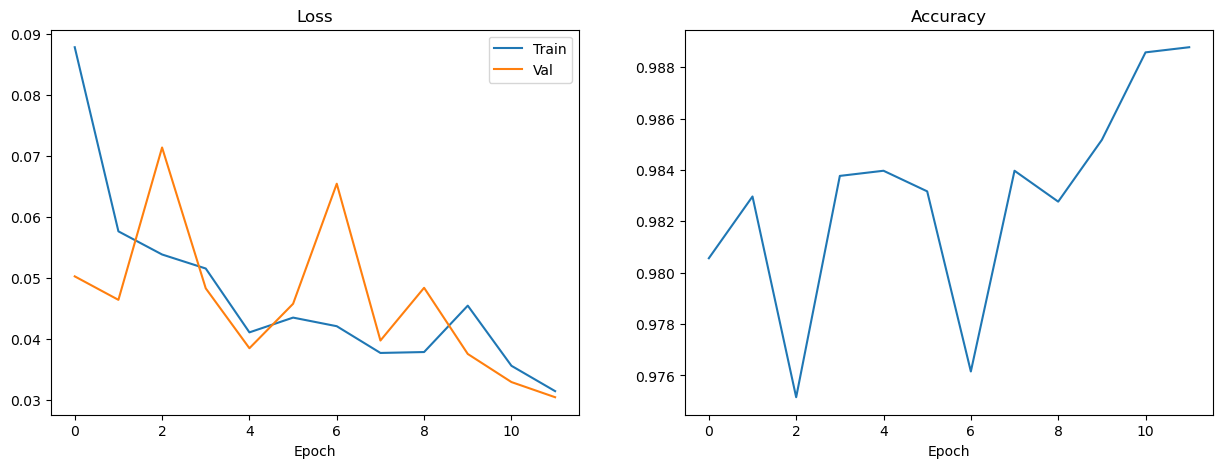

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(losses_train, label='Train')
ax[0].plot(losses_val, label='Val')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(accuracies_val)
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
plt.show()